In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_rows', 500)
#http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

In [2]:
#import data
url = "https://hbiostat.org/data/repo/rhc.csv"
df = pd.read_csv(url)

In [3]:
#variables used in the analysis
variables = ['cat1','sex','death','age','swang1','meanbp1']
df = df[variables]

In [4]:
#transform categorical variables to dummies 
df_categorical = df.select_dtypes(include = 'object')
df_dummy = pd.get_dummies(df_categorical).drop(['sex_Male','death_No','swang1_No RHC'],
                                    axis='columns')
df_dummy_columns = df_dummy.columns.str.split('_').str[1].to_list()
df_dummy.columns = df_dummy_columns
df_dummy.rename(columns = {
   'Cirrhosis': 'Cirr',
    'Colon Cancer': 'colcan',
    'Lung Cancer': 'lungcan',
    'MOSF w/Malignancy':'MOSF',
    'MOSF w/Sepsis': 'sepsis',
    'Yes':'died',
    'RHC': 'treatment'       
},
inplace = True)
#merge back
rhc = df.select_dtypes(exclude = ['object']).merge(df_dummy, left_index=True, right_index=True)

In [5]:
#check
print(rhc.iloc[5,:].age - df.iloc[5,:].age)
print(rhc.iloc[3254,:].meanbp1 - df.iloc[3254,:].meanbp1)
print(rhc.iloc[3254,:].ARF)
print(df.iloc[3254,:].cat1)

0.0
0.0
0.0
MOSF w/Sepsis


## 1. Assess Balance using SMD
calculated by the difference in the means between the two groups divided by the pooled standard deviation
### Rule of thumb:
* Values < 0.1 indicate adequate balance
* Values 0.1-0.2 are not too alarming
* Values > 0.2 indicate serious imbalance

### 1.1 Using Tableon Package

In [7]:
#https://github.com/tompollard/tableone/blob/master/tableone/tableone.py
from tableone import TableOne
import warnings
warnings.filterwarnings('ignore')

In [8]:
columns = rhc.columns.to_list()
categorical = rhc.columns[2:-1].to_list()

In [9]:
TableOne(rhc, 
         columns=columns, 
         categorical=categorical,
         groupby='treatment',
         smd = True, 
         pval=True,
         pval_test_name = True,
         missing = False)

Grouped by treatment                                                                
                                  Overall            0             1 P-Value               Test SMD (0,1)
n                                    5735         3551          2184                                     
age, mean (SD)                61.4 (16.7)  61.8 (17.3)   60.7 (15.6)   0.022  Two Sample T-test    -0.061
meanbp1, mean (SD)            78.5 (38.0)  84.9 (38.9)   68.2 (34.2)  <0.001  Two Sample T-test    -0.455
ARF, n (%)         0          3245 (56.6)  1970 (55.5)   1275 (58.4)   0.034        Chi-squared     0.059
                   1          2490 (43.4)  1581 (44.5)    909 (41.6)                                     
CHF, n (%)         0          5279 (92.0)  3304 (93.0)   1975 (90.4)  <0.001        Chi-squared     0.095
                   1            456 (8.0)    247 (7.0)     209 (9.6)                                     
COPD, n (%)        0          5278 (92.0)  3152 (88.8)   2126 (97.3)  <0.001        Chi-squared     0.342
                   1            457 (8.0)   399 (11.2)      58 (2.7)                                     
Cirr, n (%)        0          5511 (96.1)  3376 (95.1)   2135 (97.8)  <0.001        Chi-squared     0.145
                   1            224 (3.9)    175 (4.9)      49 (2.2)                                     
colcan, n (%)      0          5728 (99.9)  3545 (99.8)  2183 (100.0)   0.264     Fisher's exact     0.038
                   1              7 (0.1)      6 (0.2)       1 (0.0)                                     
Coma, n (%)        0          5299 (92.4)  3210 (90.4)   2089 (95.7)  <0.001        Chi-squared     0.207
                   1            436 (7.6)    341 (9.6)      95 (4.3)                                     
lungcan, n (%)     0          5696 (99.3)  3517 (99.0)   2179 (99.8)   0.002        Chi-squared     0.095
                   1             39 (0.7)     34 (1.0)       5 (0.2)                                     
MOSF, n (%)        0          5336 (93.0)  3310 (93.2)   2026 (92.8)   0.553        Chi-squared     0.018
                   1            399 (7.0)    241 (6.8)     158 (7.2)                                     
sepsis, n (%)      0          4508 (78.6)  3024 (85.2)   1484 (67.9)  <0.001        Chi-squared     0.415
                   1          1227 (21.4)   527 (14.8)    700 (32.1)                                     
Female, n (%)      0          3192 (55.7)  1914 (53.9)   1278 (58.5)   0.001        Chi-squared     0.093
                   1          2543 (44.3)  1637 (46.1)    906 (41.5)                                     
died, n (%)        0          2013 (35.1)  1315 (37.0)    698 (32.0)  <0.001        Chi-squared     0.107
                   1          3722 (64.9)  2236 (63.0)   1486 (68.0)

### 1.2 Using self defined functions

In [10]:
#https://causalml.readthedocs.io/en/latest/_modules/causalml/match.html
def smd(feature, treatment):
    """Calculate the standard mean difference (SMD) of a feature between the
    treatment and control groups.

    The definition is available at
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/#s11title

    Args:
        feature (pandas.Series): a column of a feature to calculate SMD for
        treatment (pandas.Series): a column that indicate whether a row is in
                                   the treatment group or not

    Returns:
        (float): The SMD of the feature
    """
    t = feature[treatment == 1]
    c = feature[treatment == 0]
    return abs((t.mean() - c.mean()) / np.sqrt(.5 * (t.var() + c.var())))

In [11]:
def create_table_one(data, treatment_col, features):
    """Report balance in input features between the treatment and control groups.

    References:
        R's tableone at CRAN: https://github.com/kaz-yos/tableone
        Python's tableone at PyPi: https://github.com/tompollard/tableone

    Args:
        data (pandas.DataFrame): total or matched sample data
        treatment_col (str): the column name for the treatment
        features (list of str): the column names of features

    Returns:
        (pandas.DataFrame): A table with the means and standard deviations in
            the treatment and control groups, and the SMD between two groups
            for the features.
    """
    t1 = pd.pivot_table(data[features + [treatment_col]],
                        columns=treatment_col,
                        aggfunc=[lambda x: '{:.2f} ({:.2f})'.format(x.mean(),
                                                                    x.std())])
    t1.columns = t1.columns.droplevel(level=0)
    t1['SMD'] = data[features].apply(
        lambda x: smd(x, data[treatment_col])
    ).round(4)

    n_row = pd.pivot_table(data[[features[0], treatment_col]],
                           columns=treatment_col,
                           aggfunc=['count'])
    n_row.columns = n_row.columns.droplevel(level=0)
    n_row['SMD'] = ''
    n_row.index = ['n']

    t1 = pd.concat([n_row, t1], axis=0)
    t1.columns.name = ''
    t1.columns = ['Control', 'Treatment', 'SMD']
    t1.index.name = 'Variable'

    return t1

In [12]:
create_table_one(rhc,'treatment',features = rhc.columns[0:-1].to_list())

,Control,Treatment,SMD
Variable,,,
n,3551,2184,
ARF,0.45 (0.50),0.42 (0.49),0.0586
CHF,0.07 (0.25),0.10 (0.29),0.095
COPD,0.11 (0.32),0.03 (0.16),0.3424
Cirr,0.05 (0.22),0.02 (0.15),0.1447
Coma,0.10 (0.29),0.04 (0.20),0.2073
Female,0.46 (0.50),0.41 (0.49),0.0931
MOSF,0.07 (0.25),0.07 (0.26),0.0175
age,61.76 (17.29),60.75 (15.63),0.0614


## 2. Matching

### 2.1 Matching on Covariates using knn

In [13]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.proportion as prop

In [14]:
# test: non-transformed test with all columns
# control: non-transformed control with all columns
# covariates: non-transformed covariates
# X_transformed: transformed covariates
# rhc_transform: transformed covariates with label
# test_transfrom: transformed covariates with label
# control_transfrom: transformed covariates with label

In [15]:
test = rhc[rhc.treatment == 1].reset_index(drop = True)
control = rhc[rhc.treatment == 0].reset_index(drop = True)
covariates = rhc.drop(['treatment','died'], axis = 'columns')

In [16]:
scaler = StandardScaler()
scaler.fit(covariates)
X= scaler.transform(covariates)
X_transform = pd.DataFrame(X)
X_transform.columns = covariates.columns

In [17]:
rhc_transform = pd.concat([X_transform, rhc['treatment']], axis = 1)
test_transfrom = rhc_transform[rhc_transform.treatment == 1].drop(['treatment'], axis = 'columns').reset_index(drop=True)
control_transfrom = rhc_transform[rhc_transform.treatment == 0].drop(['treatment'], axis = 'columns').reset_index(drop=True)

#### 2.1.1 Match on k = 1

In [18]:
nbrs = NearestNeighbors(n_neighbors=1).fit(control_transfrom)
indices = nbrs.kneighbors(test_transfrom,return_distance=False)
test_id = indices.reshape(1,indices.size)[0].tolist()

In [19]:
#the algorithm match data with replacement
len(set(test_id))

1341

In [20]:
rhc_matched = pd.concat([control.iloc[test_id,:],test]).reset_index(drop = True)
create_table_one(rhc_matched,'treatment',features = rhc_matched.columns[0:-2].to_list())

,Control,Treatment,SMD
Variable,,,
n,2184,2184,
ARF,0.42 (0.49),0.42 (0.49),0.0
CHF,0.10 (0.29),0.10 (0.29),0.0
COPD,0.03 (0.16),0.03 (0.16),0.0
Cirr,0.02 (0.15),0.02 (0.15),0.0
Coma,0.04 (0.20),0.04 (0.20),0.0
Female,0.41 (0.49),0.41 (0.49),0.0
MOSF,0.07 (0.26),0.07 (0.26),0.0
age,60.82 (15.53),60.75 (15.63),0.0045


In [21]:
#Z test to calculate the effect

In [22]:
n=len(rhc_matched)/2
#experiment
count1 = sum(rhc_matched[rhc_matched['treatment'] == 0].died)
nobs1 = n
#control
count2 = sum(rhc_matched[rhc_matched['treatment'] == 1].died)
nobs2 = n

In [23]:
#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.test_proportions_2indep.html#statsmodels.stats.proportion.test_proportions_2indep
prop.test_proportions_2indep(count2, nobs2,count1, nobs1,   
                             value=None, method=None, 
                             compare='diff', alternative='two-sided', 
                             correction=True, return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 3.1589336858694823
pvalue = 0.0015834751658695288
compare = diff
method = agresti-caffo
diff = 0.04532967032967039
ratio = 1.071377072819034
odds_ratio = 1.2233345659552584
variance = 0.0002055365468787332
alternative = two-sided
value = 0
tuple = (3.1589336858694823, 0.0015834751658695288)

In [24]:
prop.confint_proportions_2indep(count2, nobs2,count1, nobs1,   
                                method=None, compare='diff', alpha=0.05, correction=False)

(0.017189713859022238, 0.07336953859455371)

#### 2.1.2 Match on k = 2

In [25]:
nbrs_2 = NearestNeighbors(n_neighbors=2).fit(control_transfrom)
indices_2 = nbrs_2.kneighbors(test_transfrom,return_distance=False)
test_id_2 = indices_2.reshape(1,indices_2.size)[0].tolist()

In [26]:
#the algorithm match data with replacement
len(set(test_id_2))

2014

In [27]:
rhc_matched_2 = pd.concat([control.iloc[test_id_2,:],test]).reset_index(drop = True)
create_table_one(rhc_matched_2,'treatment',features = rhc_matched_2.columns[0:-2].to_list())

,Control,Treatment,SMD
Variable,,,
n,4368,2184,
ARF,0.42 (0.49),0.42 (0.49),0.0
CHF,0.10 (0.29),0.10 (0.29),0.0
COPD,0.03 (0.16),0.03 (0.16),0.0
Cirr,0.02 (0.15),0.02 (0.15),0.0
Coma,0.04 (0.20),0.04 (0.20),0.0
Female,0.41 (0.49),0.41 (0.49),0.0005
MOSF,0.07 (0.26),0.07 (0.26),0.0
age,60.81 (15.46),60.75 (15.63),0.004


In [28]:
#Z test to calculate the effect

#experiment
count1 = sum(rhc_matched_2[rhc_matched_2['treatment'] == 0].died)
nobs1 = len(rhc_matched_2[rhc_matched_2['treatment'] == 0])
#control
count2 = sum(rhc_matched_2[rhc_matched_2['treatment'] == 1].died)
nobs2 = len(rhc_matched_2[rhc_matched_2['treatment'] == 1])

#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.test_proportions_2indep.html#statsmodels.stats.proportion.test_proportions_2indep
prop.test_proportions_2indep(count2, nobs2,count1, nobs1,   
                             value=None, method=None, 
                             compare='diff', alternative='two-sided', 
                             correction=True, return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 3.6067638924463905
pvalue = 0.0003100395323345437
compare = diff
method = agresti-caffo
diff = 0.044642857142857206
ratio = 1.0702196615052215
odds_ratio = 1.219713095598
variance = 0.00015249786667204847
alternative = two-sided
value = 0
tuple = (3.6067638924463905, 0.0003100395323345437)

In [29]:
prop.confint_proportions_2indep(count2, nobs2,count1, nobs1,   
                                method=None, compare='diff', alpha=0.05, correction=False)

(0.020260615953076364, 0.06865409432708194)

### 2.2 Matching on propensity score

#### 2.2.1 Using PyMatch Package

In [30]:
#https://github.com/benmiroglio/pymatch
from pymatch.Matcher import Matcher

In [31]:
m = Matcher(test, control, yvar='treatment', exclude=['died'])

Formula:
treatment ~ age+meanbp1+ARF+CHF+COPD+Cirr+colcan+Coma+lungcan+MOSF+sepsis+Female
n majority: 3551
n minority: 2184


* There is a significant Class Imbalance in our data--the majority group (fully-paid loans) having many more records than the minority group (defaulted loans). We account for this by setting balance=True when calling Matcher.fit_scores()

* nmodels is a parameter to indicate how many models we will fit. The result will be average of the models

In [32]:
# for reproducibility
np.random.seed(20170925)
#
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 63.33%


In [33]:
m.predict_scores()

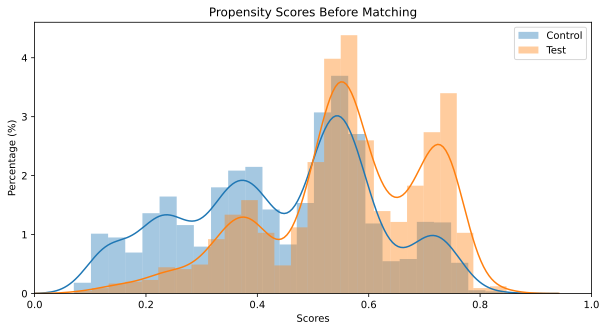

In [34]:
#check the balance between control and test group
m.plot_scores()

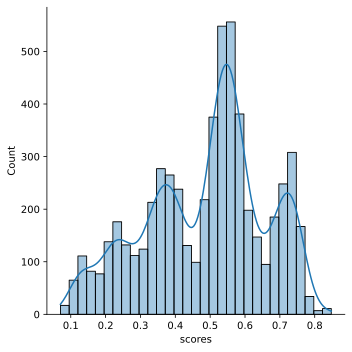

In [35]:
#check the distribution of score to see if there is any unusual data
sns.displot(data=m.data, x="scores", alpha=0.4,kde = True)

In [36]:
# In practice set the caliper to 0.2* standard deviation
np.std(m.data['scores'])*0.2

0.03405210114528166

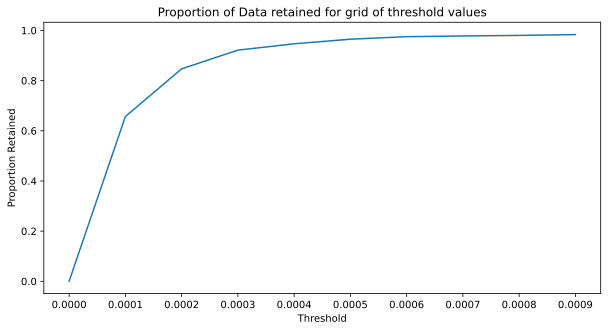

In [37]:
m.tune_threshold(method='random')

In [38]:
m.match(method="min", nmatches=2, threshold=0.001)
m.record_frequency()

,freq,n_records
0,1,3125
1,2,490
2,3,285
3,4,150
4,5,79
5,6,30
6,7,19
7,8,9
8,9,7
9,10,6


In [39]:
matched_rhc = m.matched_data
print('Number of obvervatiosn in control group:', sum(matched_rhc.treatment ==0))
print('Number of obvervatiosn in test group:', sum(matched_rhc.treatment ==1))

Number of obvervatiosn in control group: 4368
Number of obvervatiosn in test group: 2184


In [40]:
#check balance
create_table_one(matched_rhc,'treatment',features = matched_rhc.columns[0:-5].to_list())

,Control,Treatment,SMD
Variable,,,
n,4368,2184,
ARF,0.40 (0.49),0.42 (0.49),0.0237
CHF,0.10 (0.30),0.10 (0.29),0.026
COPD,0.02 (0.15),0.03 (0.16),0.0313
Cirr,0.02 (0.15),0.02 (0.15),0.0031
Coma,0.04 (0.21),0.04 (0.20),0.0034
Female,0.42 (0.49),0.41 (0.49),0.0181
MOSF,0.07 (0.26),0.07 (0.26),0.0035
age,61.06 (18.05),60.75 (15.63),0.0186


In [41]:
# A test to calculate the effect
count1 = sum(matched_rhc[matched_rhc['treatment'] == 0].died)
nobs1 = sum(matched_rhc.treatment ==0)
count2 = sum(matched_rhc[matched_rhc['treatment'] == 1].died)
nobs2 = sum(matched_rhc.treatment ==1)

In [42]:
prop.test_proportions_2indep(count2, nobs2,count1, nobs1,   
                             value=None, method=None, 
                             compare='diff', alternative='two-sided', 
                             correction=True, return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 3.4781918962591214
pvalue = 0.0005048083955833178
compare = diff
method = agresti-caffo
diff = 0.04304029304029311
ratio = 1.067528735632184
odds_ratio = 1.2112933504594412
variance = 0.00015239779891331834
alternative = two-sided
value = 0
tuple = (3.4781918962591214, 0.0005048083955833178)

In [43]:
prop.confint_proportions_2indep(count2, nobs2,count1, nobs1,   
                                method=None, compare='diff', alpha=0.05, correction=False)

(0.018666683468282774, 0.06704430337841714)

#### 2.2.2 Calculating the score and matching using Scikit-Learn

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
logistic = LogisticRegression().fit(X=covariates, y=rhc.treatment)

In [46]:
pscore = pd.DataFrame(logistic.predict_proba(covariates)[:, 1],columns = ['pscore'])

In [47]:
rhc_score = pd.concat([rhc,pscore],axis = 1)

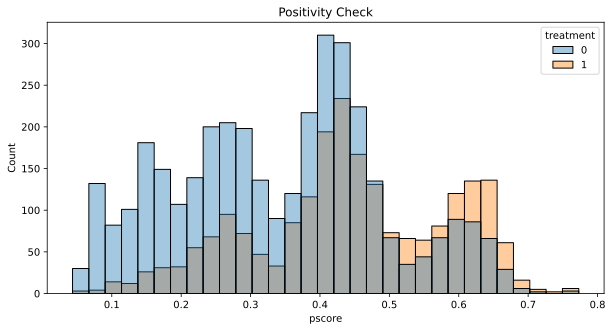

In [50]:
sns.histplot(data=rhc_score, x="pscore", hue="treatment", alpha=0.4)
plt.title("Positivity Check")
plt.show()

In [51]:
control_score = rhc_score[rhc_score.treatment ==0].reset_index(drop=True)
test_score = rhc_score[rhc_score.treatment ==1].reset_index(drop=True)

In [52]:
nbrs_score = NearestNeighbors(n_neighbors=2).fit(control_score[['pscore']])
indices_score = nbrs_score.kneighbors(test_score[['pscore']],return_distance=False)
score_test_id = indices_score.reshape(1,indices_score.size)[0].tolist()

In [53]:
rhc_score_matched = pd.concat([control_score.iloc[score_test_id,:],test_score]).reset_index(drop = True)

In [54]:
create_table_one(rhc_score_matched,'treatment',features = rhc_score_matched.columns[0:-3].to_list())

,Control,Treatment,SMD
Variable,,,
n,4368,2184,
ARF,0.41 (0.49),0.42 (0.49),0.0139
CHF,0.10 (0.30),0.10 (0.29),0.0054
COPD,0.03 (0.16),0.03 (0.16),0.0057
Cirr,0.02 (0.15),0.02 (0.15),0.0136
Coma,0.04 (0.19),0.04 (0.20),0.0278
Female,0.42 (0.49),0.41 (0.49),0.0084
MOSF,0.08 (0.27),0.07 (0.26),0.0148
age,60.71 (18.00),60.75 (15.63),0.0024


In [55]:
#experiment
count1 = sum(rhc_score_matched[rhc_score_matched['treatment'] == 0].died)
nobs1 = len(rhc_score_matched[rhc_score_matched['treatment'] == 0])
#control
count2 = sum(rhc_score_matched[rhc_score_matched['treatment'] == 1].died)
nobs2 = len(rhc_score_matched[rhc_score_matched['treatment'] == 1])

In [56]:
#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.test_proportions_2indep.html#statsmodels.stats.proportion.test_proportions_2indep
prop.test_proportions_2indep(count2, nobs2,count1, nobs1,   
                             value=None, method=None, 
                             compare='diff', alternative='two-sided', 
                             correction=True, return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 3.6802022633866063
pvalue = 0.00023304902637784417
compare = diff
method = agresti-caffo
diff = 0.04555860805860812
ratio = 1.0717634331049406
odds_ratio = 1.22454346404182
variance = 0.00015255452100844844
alternative = two-sided
value = 0
tuple = (3.6802022633866063, 0.00023304902637784417)

In [57]:
prop.confint_proportions_2indep(count2, nobs2,count1, nobs1,   
                                method=None, compare='diff', alpha=0.05, correction=False)

(0.021171476289358775, 0.0695739306901984)

In [58]:
#self_define caliper
#https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb

## 3. IPTW

In [59]:
#calculate Weight
rhc_score['weight'] = rhc_score.apply(lambda x: 1/x['pscore'] if x['treatment'] == 1 else 1/(1-x['pscore']),axis = 1)

In [60]:
#understand the distribution of weight
rhc_score['weight'].describe()
#the max of weight is 21, so I will not truncate it

count    5735.000000
mean        1.997781
std         1.084578
min         1.045407
25%         1.407037
50%         1.720320
75%         2.279618
max        21.747692
Name: weight, dtype: float64

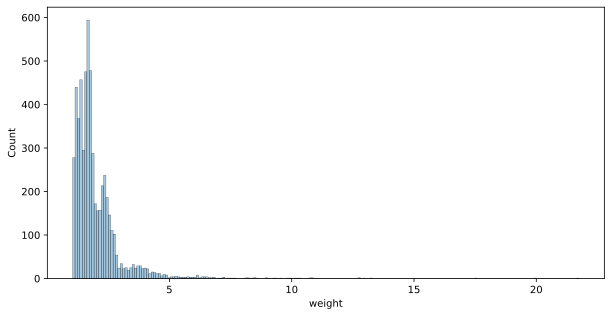

In [61]:
sns.histplot(data=rhc_score, x="weight", alpha=0.4)
plt.show()

In [62]:
#conform SMD
def calculate_smd_weight(data, feature, treatment, weight):
    """Calculate the weighted standard mean difference (SMD) of a feature between the
    treatment and control groups.


    Args:
        data (pandas.DataFrame)
        feature (pandas.Series): a column of a feature to calculate SMD for
        treatment (pandas.Series): a column that indicate whether a row is in
                                   the treatment group or not
        weight (pandas.Series): a column of weight

    Returns:
        (float): The SMD of the feature
    """
    from statsmodels.stats.weightstats import DescrStatsW
    smd_covariates = {}
    t = data[data[treatment] ==1]
    c = data[data[treatment] ==0]
    for i in feature:
        weighted_stats_1 = DescrStatsW(t[i], t[weight])
        weighted_stats_0 = DescrStatsW(c[i], c[weight])
        smd_covariates[i] = abs((weighted_stats_1.mean - weighted_stats_0.mean) / np.sqrt(.5 * (weighted_stats_1.var + weighted_stats_0.var)))
    t1 = pd.DataFrame.from_dict(smd_covariates, orient='index',columns = ['SMD'])
    return t1

In [63]:
calculate_smd_weight(rhc_score,covariates.columns, 'treatment','weight')

,SMD
age,0.001943
meanbp1,0.010086
ARF,0.016236
CHF,0.002607
COPD,0.006338
Cirr,0.005912
colcan,0.002862
Coma,0.027732
lungcan,0.047684
MOSF,0.002013


In [73]:
rhc_score['died_weight'] = rhc_score.died*rhc_score.weight

In [75]:
#experiment
count1 = sum(rhc_score[rhc_score['treatment'] == 1].died_weight)
nobs1 = sum(rhc_score[rhc_score.treatment ==1].weight)
#control
count2 = sum(rhc_score[rhc_score['treatment'] == 0].died_weight)
nobs2 = sum(rhc_score[rhc_score.treatment ==0].weight)

In [76]:
print("Original Sample Size", rhc_score.shape[0])
print("Treated Population Sample Size", nobs1)
print("Untreated Population Sample Size", nobs2)

Original Sample Size 5735
Treated Population Sample Size 5727.397068684874
Untreated Population Sample Size 5729.876758944067


In [78]:
#https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.test_proportions_2indep.html#statsmodels.stats.proportion.test_proportions_2indep
prop.test_proportions_2indep(count1, nobs1,count2, nobs2,   
                             value=None, method=None, 
                             compare='diff', alternative='two-sided', 
                             correction=True, return_results=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 5.687376124607952
pvalue = 1.2900611656998718e-08
compare = diff
method = agresti-caffo
diff = 0.05040887986994658
ratio = 1.0798692894195998
odds_ratio = 1.250807231512947
variance = 7.85030616352964e-05
alternative = two-sided
value = 0
tuple = (5.687376124607952, 1.2900611656998718e-08)

In [79]:
prop.confint_proportions_2indep(count1, nobs1,count2, nobs2,   
                                method=None, compare='diff', alpha=0.05, correction=False)

(0.03302406146360157, 0.06775102768094718)

## 4. Regression

### 4.1 Regression without covariates

In [135]:
import statsmodels.api as sm

In [200]:
# defining the dependent and independent variables
X = rhc[['treatment']]
X = sm.add_constant(X)
y = rhc[['died']]
   
# building the model and fitting the data
#use "link = identity" to get risk difference which return the same result as linear regression
#https://stats.stackexchange.com/questions/190763/how-to-decide-which-glm-family-to-use
glm = sm.GLM(y, X,family=sm.families.Binomial(link=sm.families.links.identity)).fit()
log_reg = sm.Logit(y, X).fit()
lin_reg = sm.OLS(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.280114
         Iterations 4


D:\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


In [178]:
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   died   No. Observations:                 5735
Model:                            GLM   Df Residuals:                     5733
Model Family:                Binomial   Df Model:                            1
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3709.0
Date:                Sun, 13 Jun 2021   Deviance:                       7417.9
Time:                        20:36:36   Pearson chi2:                 5.73e+03
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6297      0.008     77.705      0.0

In [183]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5733
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Jun 2021   Pseudo R-squ.:                     inf
Time:                        20:37:56   Log-Likelihood:                -1606.5
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5309      0.035     15.276      0.000       0.463       0.599
treatment      0.2248      0.058      3.905      0.000       0.112       0.338


In [151]:
#the coefficient of logistic regression is log(p/(1-p))

In [168]:
b0 = log_reg.params.values[0]

In [169]:
b1 = log_reg.params.values[1]

In [179]:
np.exp(b0+b1)/(1+np.exp(b0+b1)) - np.exp(b0)/(1+np.exp(b0))

0.05072115062258675

In [184]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   died   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     15.31
Date:                Sun, 13 Jun 2021   Prob (F-statistic):           9.24e-05
Time:                        20:38:11   Log-Likelihood:                -3888.1
No. Observations:                5735   AIC:                             7780.
Df Residuals:                    5733   BIC:                             7794.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6297      0.008     78.709      0.000       0.614       0.645
treatment      0.0507      0.013      3.912      0.000       0.025       0.076
==============================================================================
Omnibus:                    28988.838   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              982.605
Skew:                          -0.622   Prob(JB):                    4.27e-214
Kurtosis:                       1.398   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.2 Logistic Regression with covariates

In [196]:
# defining the dependent and independent variables
X = rhc.drop(['died'], axis = 'columns')
X = sm.add_constant(X)
y = rhc[['died']]
   
# building the model and fitting the data
glm = sm.GLM(y, X,family=sm.families.Binomial(link=sm.families.links.identity)).fit()

D:\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


In [197]:
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   died   No. Observations:                 5735
Model:                            GLM   Df Residuals:                     5722
Model Family:                Binomial   Df Model:                           12
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 13 Jun 2021   Deviance:                       6874.5
Time:                        20:50:37   Pearson chi2:                 5.40e+03
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3876      0.031     12.602      0.000       0.327       0.448
age            0.0051      0.000     15.781      0.000       0.005       0.006
meanbp1       -0.0007      0.000     -5.139      0.000      -0.001      -0.000
ARF           -0.0509      0.021     -2.413      0.016      -0.092      -0.010
CHF           -0.0549      0.028     -1.961      0.050      -0.110   -3.65e-05
COPD          -0.0503      0.028     -1.786      0.074      -0.106       0.005
Cirr           0.1042      0.033      3.178      0.001       0.040       0.169
colcan        -0.0839      0.166     -0.505      0.613      -0.409       0.242
Coma           0.1342      0.021      6.326      0.000       0.093       0.176
lungcan        0.2320      0.021     11.214      0.000       0.191       0.273
MOSF           0.1664      0.021      7.843      0.000       0.125       0.208
sepsis        -0.0091      0.023     -0.400      0.689      -0.054       0.035
Female        -0.0171      0.001    -16.974      0.000      -0.019      -0.015
treatment      0.0242      0.012      2.045      0.041       0.001       0.047
==============================================================================
"""

### 4.3 Logistic Regression with Propensity Score

In [189]:
# defining the dependent and independent variables
X = rhc_score[['pscore','treatment']]
X = sm.add_constant(X)
y = rhc_score[['died']]
   
# building the model and fitting the data
glm = sm.GLM(y, X,family=sm.families.Binomial(link=sm.families.links.identity)).fit()

D:\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


In [190]:
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   died   No. Observations:                 5735
Model:                            GLM   Df Residuals:                     5732
Model Family:                Binomial   Df Model:                            2
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3708.9
Date:                Sun, 13 Jun 2021   Deviance:                       7417.7
Time:                        20:43:15   Pearson chi2:                 5.73e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6225      0.017     37.230      0.000       0.590       0.655
pscore         0.0210      0.043      0.492      0.623      -0.063       0.105
treatment      0.0485      0.014      3.568      0.000       0.022       0.075
==============================================================================
"""

### 4.4 Weighted Logistic Regression

In [194]:
# defining the dependent and independent variables
X = rhc_score[['treatment']]
X = sm.add_constant(X)
y = rhc_score[['died']]
   
# building the model and fitting the data
glm = sm.GLM(y, X,family=sm.families.Binomial(link=sm.families.links.identity),
             freq_weights = rhc_score['weight']).fit()

D:\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:296: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


In [195]:
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   died   No. Observations:                 5735
Model:                            GLM   Df Residuals:                 11455.27
Model Family:                Binomial   Df Model:                            1
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7355.8
Date:                Sun, 13 Jun 2021   Deviance:                       14712.
Time:                        20:49:26   Pearson chi2:                 1.15e+04
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6311      0.006     99.016      0.000       0.619       0.644
treatment      0.0504      0.009      5.689      0.000       0.033       0.068
==============================================================================
"""

In [ ]:
#sandwich estimator to correct the SE

In [85]:
from causalinference import CausalModel
import numpy as np

In [ ]:
#treatment effect on covariates
causal = CausalModel(
    Y=rhc["died"].values, 
    D=rhc["treatment"].values, 
    X=rhc.drop(['died','treatment'], axis = 'columns').values
)

#Estimates average treatment effects using nearest- neighborhood matching.
#Matching is done with replacement.
causal.est_via_matching(matches=3,bias_adj=True)
print(causal.estimates)

In [134]:
#treatment effect on propensity score
cm = CausalModel(
    Y=rhc_score_matched["died"].values, 
    D=rhc_score_matched["treatment"].values, 
    X=rhc_score_matched[['pscore']].values
)

cm.est_via_ols()
#Estimates average treatment effects using nearest- neighborhood matching.
#Matching is done with replacement.
cm.est_via_matching(matches=2,bias_adj=True)
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.037      0.014      2.562      0.010      0.009      0.065
           ATC      0.037      0.014      2.562      0.010      0.009      0.065
           ATT      0.037      0.014      2.562      0.010      0.009      0.065

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.036      0.019      1.853      0.064     -0.002      0.073
           ATC      0.029      0.021      1.386      0.166     -0.012      0.071
           ATT      0.042      0.019      2.228      0.026      0.005      0.079



In [ ]:
#https://microsoft.github.io/dowhy/example_notebooks/dowhy_estimation_methods.html

In [170]:
import dowhy

In [186]:
# ge the name of common reason
covariate_names = covariates.columns.to_list()
xs = ""
for i in covariate_names:
    xs += i + "+"
xs = xs[:-1]

In [252]:
rhc_dw = rhc

In [254]:
rhc_dw.treatment = rhc_dw.treatment.apply(lambda x: True if x ==1 else False)

In [256]:
model = dowhy.CausalModel(
        data = rhc_dw,
        treatment='treatment',
        outcome='died',
        common_causes=xs.split('+')
        )

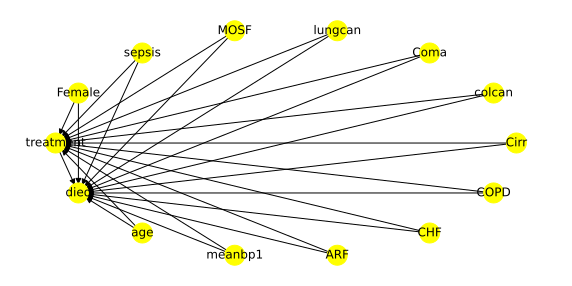

In [257]:
model.view_model()

In [258]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(died|sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Fem
d[treatment]                                                                  

                      
ale,Cirr,colcan,Coma))
                      
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→died then P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma,U) = P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [263]:
#method 1 regression
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True,
        confidence_intervals=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(died|sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Fem
d[treatment]                                                                  

                      
ale,Cirr,colcan,Coma))
                      
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→died then P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma,U) = P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma)

## Realized estimand
b: died~treatment+sepsis+age+MOSF+CHF+ARF+COPD+lungcan+meanbp1+Female+Cirr+colcan+Coma
Target units: ate

## Estimate
Mean value: 0.0503620877628157
p-value: [0.00010948]
95.0% confidence interval: [[0.02485913 0.07586505]]

Causal Estimate is 0.0503620877628157


In [266]:
#Method 2: Stratification
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att",
                                              confidence_intervals=True)
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(died|sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Fem
d[treatment]                                                                  

                      
ale,Cirr,colcan,Coma))
                      
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→died then P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma,U) = P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma)

## Realized estimand
b: died~treatment+sepsis+age+MOSF+CHF+ARF+COPD+lungcan+meanbp1+Female+Cirr+colcan+Coma
Target units: att

## Estimate
Mean value: 0.04744869263347204
95.0% confidence interval: (0.02309853661963588, 0.07437363470307999)

Causal Estimate is 0.04744869263347204


In [267]:
#method3: matching
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc",
                                              confidence_intervals= True)
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estim[ate_match.value]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(died|sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Fem
d[treatment]                                                                  

                      
ale,Cirr,colcan,Coma))
                      
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→died then P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma,U) = P(died|treatment,sepsis,age,MOSF,CHF,ARF,COPD,lungcan,meanbp1,Female,Cirr,colcan,Coma)

## Realized estimand
b: died~treatment+sepsis+age+MOSF+CHF+ARF+COPD+lungcan+meanbp1+Female+Cirr+colcan+Coma
Target units: atc

## Estimate
Mean value: 0.05801182765418192
95.0% confidence interval: (0.017887087758524316, 0.09206081081081081)

Causal Estimate is 0.05801182765418192
